# Rubin ToO Strategies
This notebook was put together to aid visualization of possible strategies to adopt for Target of Opportunity (ToO) observations with Vera C. Rubin Observatory. The notebook provides code for:
- visualization of the ToO observing strategies
- light curves plots
- exposure time calculator (ETC) to convert exposure times to limiting magnitudes and vice-versa
- time budget calculations

Notebook template author: Igor Andreoni <<igor.andreoni@gmail.com>>

### Requirements

Python3

- numpy
- matplotlib
- math
- scipy
- collections
- astropy

Custom scripts
- chart.py
- etc.py
- plot_lc.py

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd

# Import the custom exposure time calculator
import etc

# Import the function to make the Gantt chart
from chart import makeChart

Build a dictionary with the strategies that you want to be seen on the same plot. 
The keys of the dictionary will be the nicknames of the strategies (for example, `strategy1`, `strategy2`).

Notes:
- The LSSTCam filter wheel holds 5 filters on a given night. The bluer and redder filters, u and y, will be swapped depending on the lunation. If all 6 filters are added to the plot, we shall assume that 5 available filters will be used in the ToOs.
- The length of the exposure time list (`exptimes` key) must be the same length as the cadence list (`cadence_hr` key) and the filters list (`filters` key)
- The cadence must be given in hours, the exposure times in seconds, the filters as a list or in the form `'ugrizy'`
- The `depths` are 5sigma limiting magnitudes in all bands, the corresponding exptime will be the median of the exposure times for the filters provided in each strategy
- <b>Important:</b> If both "depths" and "exptimes_median" are given, "depths" will dominate. If `"depths": [ ]` and `exptimes_median` is given, then the depths will be calculated automatically.

In [2]:
# Define the strategy
strategies = {
    'Fabulous Strategy': {"cadence_hr": [4, 24, 48],
                   "exptimes_median": [], # if this list is given
                   "exptimes": [],
                   "depths": [24.5, 25, 25],
                   "filters": ['ugrizy', 'ugrizy', 'ugrizy']},
    'Less Fabulous': {"cadence_hr": [6, 48],
                   "exptimes_median": [], # if this list is given
                   "exptimes": [],
                   "depths": [24.6, 24.6],
                   "filters": ['grz', 'grz']}
}

# Airmass for the observations (>= 1.)
airmass = 1.0

# When is the timeline starting? e.g., Rubin Trigger, NS-NS merger, ...
event_name = "start of Rubin observing window"

# Output file name
filename_out = "plot_strategy.pdf"

# Define the colors for the Rubin filters
filters_color_dict = {'u':'b', 'g':'g', 'r':'r', 'i':'yellow', 'z':'k', 'y':'orange'}

# Define the sequence of markers for different exposure times
# (the sequence will be ordered by increasing exposure time)
exptimes_marker_list = ["o", "s", "p", "h", "8", '^']

## Survey Strategy Visualization

The template code was used to produce some figures published in Andreoni et al. (2022), The Astrophysical Journal Supplement Series, Volume 260, Issue 1, id.18, 17 pp.

Using DEPTHS to calculate the exposure times
Using DEPTHS to calculate the exposure times


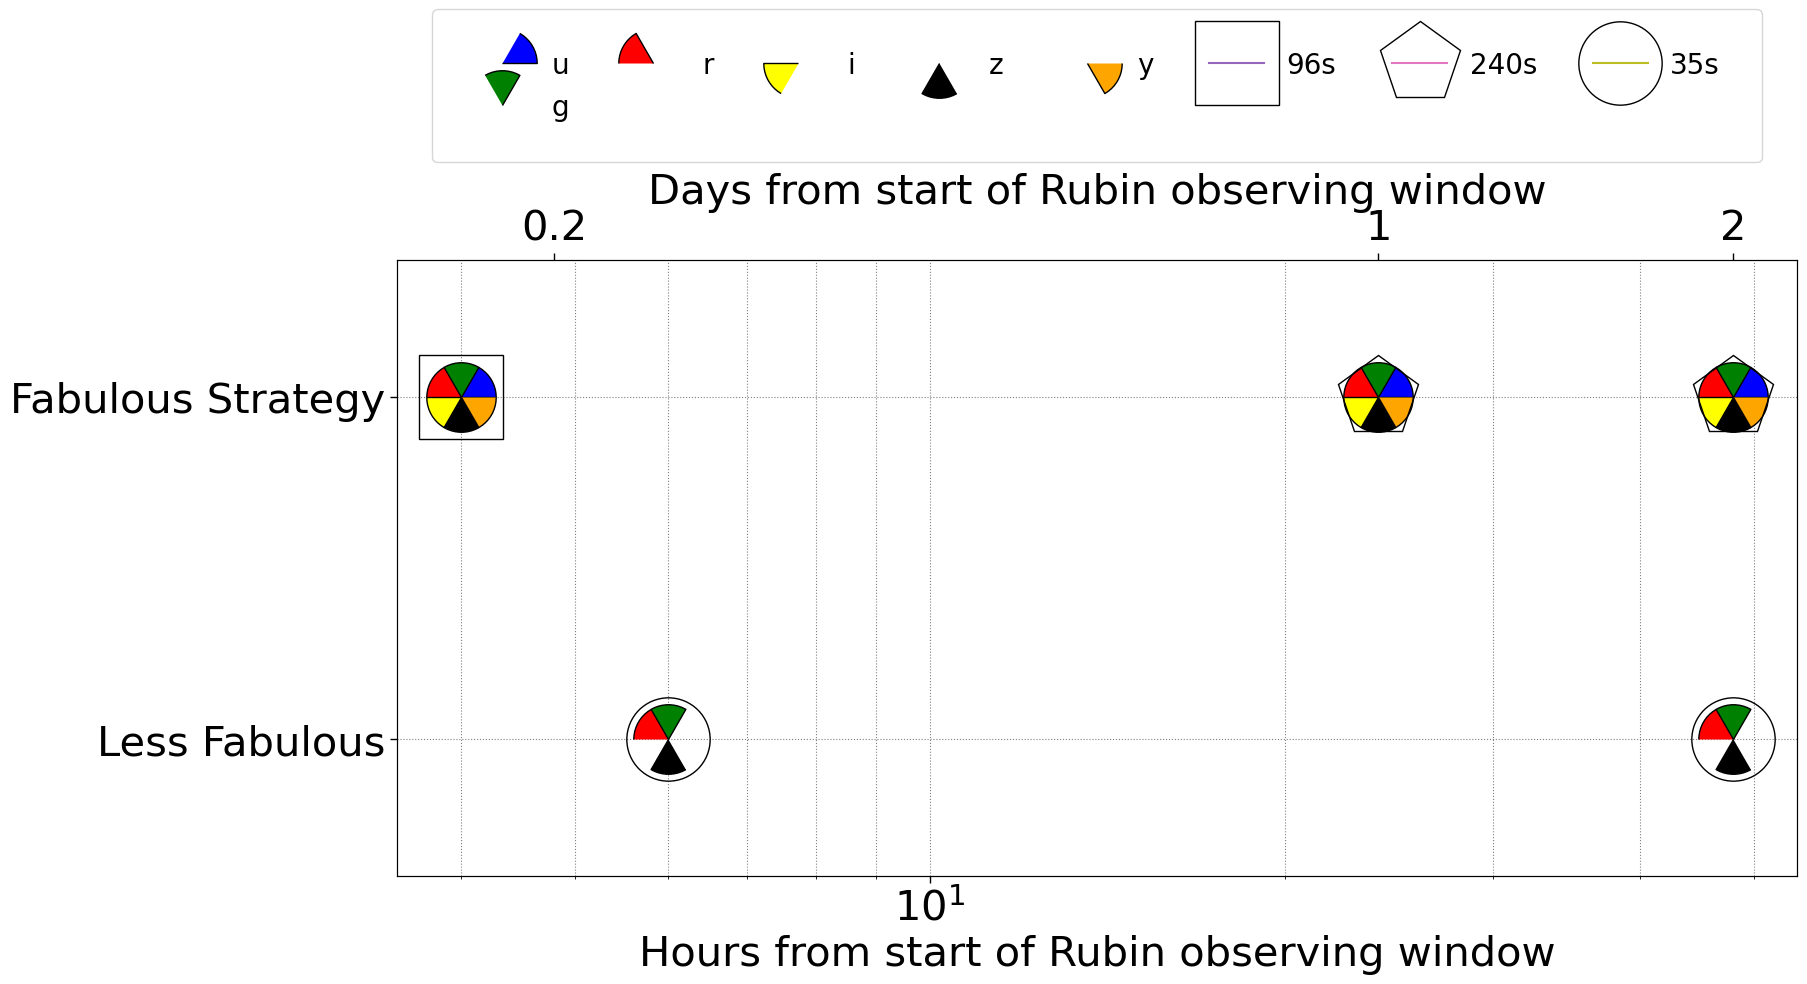

In [3]:
# If depths are given, then compute the exposure times
strategy_names = list(strategies.keys())
for i in range(len(strategy_names)):
    # Check if depths are given, as they will dominate
    if len(strategies[strategy_names[i]]["depths"]) > 0:
        print("Using DEPTHS to calculate the exposure times")
        # Initiate the exposure times list
        strategies[strategy_names[i]]["exptimes"] = []
        # Iterate over the epochs
        for j in np.arange(len(strategies[strategy_names[i]]["depths"])):
            depth = strategies[strategy_names[i]]["depths"][j]
            # Iterate over the filters
            exptimes_epoch = []
            for filt in strategies[strategy_names[i]]["filters"][j]:
                exptime = int(np.round(etc.get_exptime(depth, filt, X=airmass)))
                exptimes_epoch.append(exptime)
            # Add the average exposure time to the strategies dictionary
            strategies[strategy_names[i]]["exptimes_median"].append(int(np.round(np.median(exptimes_epoch))))
            # Detailed exposure times
            strategies[strategy_names[i]]["exptimes"].append([int(np.round(x)) for x in exptimes_epoch])
          
    else:
        print("Using MEDIAN EXPOSURE TIMES to calculate the depths")
        # Initiate the depths times list
        strategies[strategy_names[i]]["depths"] = []
        # Iterate over the epochs
        for j in np.arange(len(strategies[strategy_names[i]]["exptimes_median"])):
            exptime_median = strategies[strategy_names[i]]["exptimes_median"][j]
            # Initialize a list of depths
            depths = []
            # Get the depth for each filter
            for filt in strategies[strategy_names[i]]["filters"][j]:
                depth = int(np.round(etc.get_m5(exptime_median, filt, X=airmass)))
                depths.append(depth)
            # Exposure times for the epoch
            exptimes_epoch = [exptime_median] * len(strategies[strategy_names[i]]["filters"][j])
            # Add the median depth to the strategies dictionary
            strategies[strategy_names[i]]["depths"].append(np.median(depths))
            # Detailed exposure times
            strategies[strategy_names[i]]["exptimes"].append([int(np.round(x)) for x in exptimes_epoch])        

# Create the gantt chart
fig, ax = makeChart(strategies, event=event_name,
                    filters_color_dict=filters_color_dict,
                    exptimes_marker_list=exptimes_marker_list)

# Save the figure and show the plot
plt.savefig(filename_out, bbox_inches='tight')
plt.show()

See how the `strategies` dictionary has been populated

In [4]:
strategies

{'Fabulous Strategy': {'cadence_hr': [4, 24, 48],
  'exptimes_median': [96, 240, 240],
  'exptimes': [[131, 13, 29, 60, 170, 1088],
   [330, 32, 73, 150, 428, 2732],
   [330, 32, 73, 150, 428, 2732]],
  'depths': [24.5, 25, 25],
  'filters': ['ugrizy', 'ugrizy', 'ugrizy']},
 'Less Fabulous': {'cadence_hr': [6, 48],
  'exptimes_median': [35, 35],
  'exptimes': [[15, 35, 205], [15, 35, 205]],
  'depths': [24.6, 24.6],
  'filters': ['grz', 'grz']}}

Print the results in a more readable format

In [5]:
for i in range(len(strategy_names)):
    print(f"\n Strategy name: {strategy_names[i]}")
    # Iterate over the epochs
    for j in np.arange(len(strategies[strategy_names[i]]["depths"])):
            depth = strategies[strategy_names[i]]["depths"][j]
            print(f"    Epoch: {strategies[strategy_names[i]]['cadence_hr'][j]} hr")
            # Iterate over the filters
            for filt, exptime in zip(strategies[strategy_names[i]]["filters"][j], strategies[strategy_names[i]]["exptimes"][j]):
                print(f"        Filter: {filt} Depth: {depth}mag, exptime: {exptime}s")
            print(f"        Median exposure time: {strategies[strategy_names[i]]['exptimes_median'][j]}s")
    print("--")
    


 Strategy name: Fabulous Strategy
    Epoch: 4 hr
        Filter: u Depth: 24.5mag, exptime: 131s
        Filter: g Depth: 24.5mag, exptime: 13s
        Filter: r Depth: 24.5mag, exptime: 29s
        Filter: i Depth: 24.5mag, exptime: 60s
        Filter: z Depth: 24.5mag, exptime: 170s
        Filter: y Depth: 24.5mag, exptime: 1088s
        Median exposure time: 96s
    Epoch: 24 hr
        Filter: u Depth: 25mag, exptime: 330s
        Filter: g Depth: 25mag, exptime: 32s
        Filter: r Depth: 25mag, exptime: 73s
        Filter: i Depth: 25mag, exptime: 150s
        Filter: z Depth: 25mag, exptime: 428s
        Filter: y Depth: 25mag, exptime: 2732s
        Median exposure time: 240s
    Epoch: 48 hr
        Filter: u Depth: 25mag, exptime: 330s
        Filter: g Depth: 25mag, exptime: 32s
        Filter: r Depth: 25mag, exptime: 73s
        Filter: i Depth: 25mag, exptime: 150s
        Filter: z Depth: 25mag, exptime: 428s
        Filter: y Depth: 25mag, exptime: 2732s
        Me

## Plot transient light curve

Plot the light curve of a transient given the strategy defined above.

In [6]:
import glob

import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.ticker import MaxNLocator
from astropy.cosmology import Planck18 as cosmo
import astropy.cosmology as ac
import astropy.units as u

import plot_lc

One important variable to be set is `delay_hr`, which is the delay time between the onset of the transient (e.g., the merger of two compact objects) and the start of the observability window. Note that `cadence_hr` starts from the beginning of the observability window, since we cannot predict when the onset is, if the event happens during the Chilean daytime.

Light curve models come in ASCII or CSV files. Check out the `models/` folder and use the same format, if you want to add your favorite model. Simply assign the path to the model to the `model_filename` variable. 

A grid of kilonova light curves is available, which were obtained with 3D Monte Carlo radiative transfer code (Bulla 2019, 2023; Anand et al. 2023). Four parameters can be chosen: the dynamic ejecta mass `mej_dyn`, the disk wind ejecta mass `mej_wind`, the half opening angle of the lanthanide-rich dynamical-ejecta component `phi` and the viewing angle `theta` (see Dietrich et al. 2020, for more details about the adopted geometry). The grid is available for kilonovae at distances from 100Mpc to 700Mpc, which is twice the upper bound of the projected horizon for BNS mergers in O5, at intervals of 100Mpc. More of such light curves can be produced on demand (ask Igor). The best-fit parameters to GW170817, ignoring the distance, are:

```
inj_params_list = [{'mej_dyn': 0.005,
              'mej_wind': 0.050,
              'phi': 30,
              'theta': 25.8,
              'dist_Mpc': 300  #  Distance (Mpc), available from 100Mpc to 700Mpc at 100Mpc intervals
                   }]
```
Suggestions for parameters that can be used to probe a good range of models can be found in Table 2 in
[Andreoni et al. (2023)](https://ui.adsabs.harvard.edu/abs/2024APh...15502904A/abstract).

In [7]:
# Delay between transient onset and start of the observing window
delay_hr = 6.

# Get a model from the Bulla+19, Anand+23 model grid. Ignore this if you want to use a specific file
inj_params_list = [{'mej_dyn': 0.005,
              'mej_wind': 0.050,
              'phi': 30,
              'theta': 25.8,
              'dist_Mpc': 300  # Available from 100 to 700 Mpc, at intervals of 100Mpc
                   }]

model_filenames = plot_lc.get_kne_filename(inj_params_list=None, datadir='models/kilonova_Bulla')
model_filename = model_filenames[0]

In [8]:
model_filename

'models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.20_wind0.050-0.03_theta25.84_dMpc300.dat'


 Strategy name: Fabulous Strategy


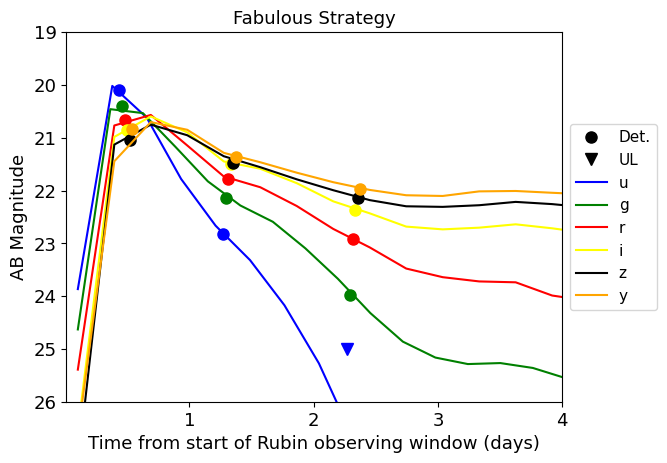


 Strategy name: Less Fabulous


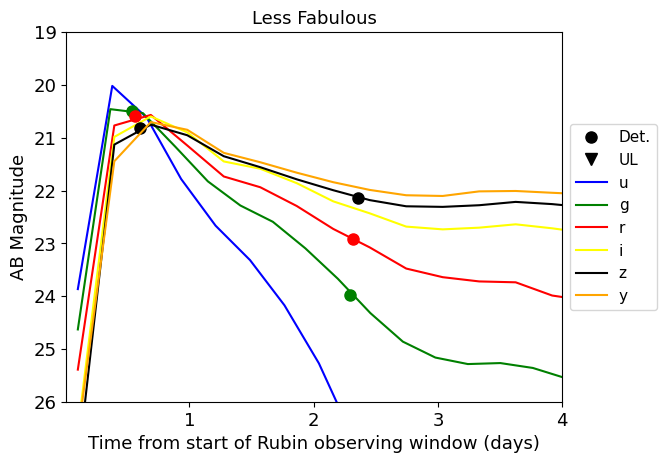

In [9]:
# Read the model
t_model = ascii.read(model_filename)
# Do plot 
plot_lc.doPlotLc(strategies, t_model,
                 delay_hr,  # delay time between merger and observing window
                 xlim=[0.01, 4], # x axis limit in apparent mag
                 ylim=[26, 19],  # y axis limit in apparent mag
                 n_interp=100,  # Number of points for the interpolation (e.g. 150)
                 offset_filt_hr=0.5,  # offset in hours between filters (to show overlapping points)
                 outfile_base="plot_lc",  # Base name for the file to be saved
                 outfile_format='pdf',  # Format of the output plot (pdf, png, etc)
                 doSave=True,  # If set to False, the plot will not be saved
                 event_name=event_name,  # Name of the event for the X label
                 linestyle="-",
                 filters_color_dict=filters_color_dict)

## Time budget

Based on the strategies adopted, compute the time budget. Some parameters need to be defined, such as overheads between exposures and rates.

Overheads are calculated by multiplying the overhead per exposure * the number of exposures, which accounts for slewing to the first field.

In [10]:
# Overheads
overhead_between_exposures = 10.  # in seconds

# Overhead first slew per epoch, assuming it may be further away than tiling
overhead_first_slew = 30

# Number of fields
n_fields = 10

# Number of events to follow-up
n_events = 5

In [11]:
for i in range(len(strategy_names)):
    exptimes = strategies[strategy_names[i]]["exptimes"]
    # Number of exposures
    n_exposures = len(np.concatenate(exptimes))
    # calculate the overheads, convert overhead from s hours
    overheads = np.sum(overhead_between_exposures/60/60 * (n_exposures-1)) + overhead_first_slew * len(exptimes)/60/60
    # calculate the total exposure time per field/pointing in hours
    total_exposure_time_hr = np.sum(np.concatenate(exptimes))/60/60
    # calculate the time budget in hours
    budget_strategy_hr = total_exposure_time_hr + overheads
    {'{:.1f}'.format(budget_strategy_hr)}
    
    print(f"\n Strategy name: {strategy_names[i]}")
    print(f"Total exposure time per pointing: {'{:.1f}'.format(total_exposure_time_hr)}hr")
    print(f"Total overheads per pointing: {'{:.2f}'.format(overheads)} ({overheads/budget_strategy_hr}% of total budget)")
    print(f"Total time budget per pointing: {'{:.1f}'.format(budget_strategy_hr)}hr")
    print(f"Total time for {n_fields} fields: {'{:.1f}'.format(budget_strategy_hr * n_fields)}hr")
    print(f"Total time for {n_fields} fields and {n_events} events: {'{:.1f}'.format(budget_strategy_hr * n_fields * n_events)}hr")
    print("-- \n")


 Strategy name: Fabulous Strategy
Total exposure time per pointing: 2.5hr
Total overheads per pointing: 0.07 (0.028135483172816788% of total budget)
Total time budget per pointing: 2.6hr
Total time for 10 fields: 25.7hr
Total time for 10 fields and 5 events: 128.3hr
-- 


 Strategy name: Less Fabulous
Total exposure time per pointing: 0.1hr
Total overheads per pointing: 0.03 (0.1774193548387097% of total budget)
Total time budget per pointing: 0.2hr
Total time for 10 fields: 1.7hr
Total time for 10 fields and 5 events: 8.6hr
-- 



## Exposure Time Calculator

From a given filter and magnitude limit (5 sigma), get the exposure time. The formulae were obtained from Formulae from [SMTN 002](https://smtn-002.lsst.io/v/OPSIM-1134/index.html).

The formula to go from the magnitude limit to the exposure time was slightly simplified, but it is accurate within 0.28s for 30s exposures.

In [12]:
# Import the custom exposure time calculator
import etc

In [13]:
# Define filters and magnitude limits
filters = "ugrizy"
mag_limits = [24.5, 24.5, 24.5, 24.5, 24.5, 24.5]  # in AB mag

# Define airmass (>= 1)
airmass = 1.

In [14]:
print("filter, mag_limit, exptime (s)")
for filt, mag in zip(filters, mag_limits):
    exptime = int(np.round(etc.get_exptime(mag, filt, X=airmass)))
    print(f"{filt}, {mag}, {exptime}")

filter, mag_limit, exptime (s)
u, 24.5, 131
g, 24.5, 13
r, 24.5, 29
i, 24.5, 60
z, 24.5, 170
y, 24.5, 1088


Now from a given filter and exposure time, get the magnitude limit (5 sigma)

In [15]:
# Define filters and exp times
filters = "ugrizy"
exptimes = [30, 30, 60, 60, 60, 60]  # in seconds

# Define airmass (>= 1)
airmass = 1.

In [16]:
print("filter, mag_limit, exptime (s)")
for filt, exptime in zip(filters, exptimes):
    mag = etc.get_m5(exptime, filt, X=airmass)
    print(f"{filt}, {'{:.1f}'.format(mag)}, {exptime}")

filter, mag_limit, exptime (s)
u, 23.7, 30
g, 25.0, 30
r, 24.9, 60
i, 24.5, 60
z, 23.9, 60
y, 22.9, 60
